> edit

# import

In [4]:
import itstgcn 
import torch
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import random

In [10]:
class Eval_csy:
    def __init__(self,learner,train_dataset):
        self.learner = learner
        # self.learner.model.eval()
        try:self.learner.model.eval()
        except:pass
        self.train_dataset = train_dataset
        self.lags = self.learner.lags
        rslt_tr = self.learner(self.train_dataset) 
        self.X_tr = rslt_tr['X']
        self.y_tr = rslt_tr['y']
        self.f_tr = torch.concat([self.train_dataset[0].x.T,self.y_tr],axis=0).float()
        self.yhat_tr = rslt_tr['yhat']
        self.fhat_tr = torch.concat([self.train_dataset[0].x.T,self.yhat_tr],axis=0).float()

In [11]:
import pickle
import pandas as pd

In [12]:
def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

# Example

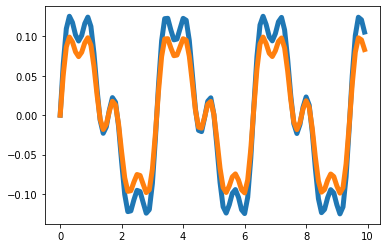

In [13]:
T = 100
t = np.arange(T)/T * 10 

x = 0.3*np.sin(2*t)+0.1*np.sin(4*t)+0.1*np.sin(8*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
# for i in range(2,T):
#     y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.5*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x*0.38
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

# _FX1 = np.stack([x,y],axis=1).tolist()
_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
#data_dict = itstgcn.load_data('./data/fivenodes.pkl')

save_data(data_dict1, './data/toy_example1.pkl')

data1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

save_data(data1, './data/toy_example_true1.csv')


In [14]:
data_dict1 = itstgcn.load_data('./data/toy_example1.pkl')
loader1 = itstgcn.DatasetLoader(data_dict1)

In [15]:
dataset05031 = loader1.get_dataset(lags=1)

In [16]:
# mindex05031 = itstgcn.rand_mindex(dataset05031,mrate=0)
# dataset_miss05031 = itstgcn.miss(dataset05031,mindex05031,mtype='rand')

In [17]:
mindex = [random.sample(range(0, T), int(T*0.6)),[np.array(list(range(40,60)))]]
dataset_miss05031 = itstgcn.miss(dataset05031,mindex,mtype='block')

/home/csy/Dropbox/blog/posts/GCN/itstgcn/utils.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/torch/csrc/utils/tensor_new.cpp:201.)
  lags = torch.tensor(train_dataset.features).shape[-1]


In [18]:
dataset_padded_cubic05031 = itstgcn.padding(dataset_miss05031,imputation_method='cubic')

`-` 학습

In [19]:
lrnr05031 = itstgcn.StgcnLearner(dataset_padded_cubic05031)

In [20]:
lrnr05031.learn(filters=8,epoch=50)

In [21]:
df1 = itstgcn.load_data('./data/toy_example_true1.csv')

In [22]:
evtor05031 = Eval_csy(lrnr05031,dataset_padded_cubic05031)

In [23]:
lrnr05032 = itstgcn.ITStgcnLearner(dataset_padded_cubic05031)

In [24]:
lrnr05032.learn(filters=8,epoch=50)

In [25]:
evtor05032 = Eval_csy(lrnr05032,dataset_padded_cubic05031)

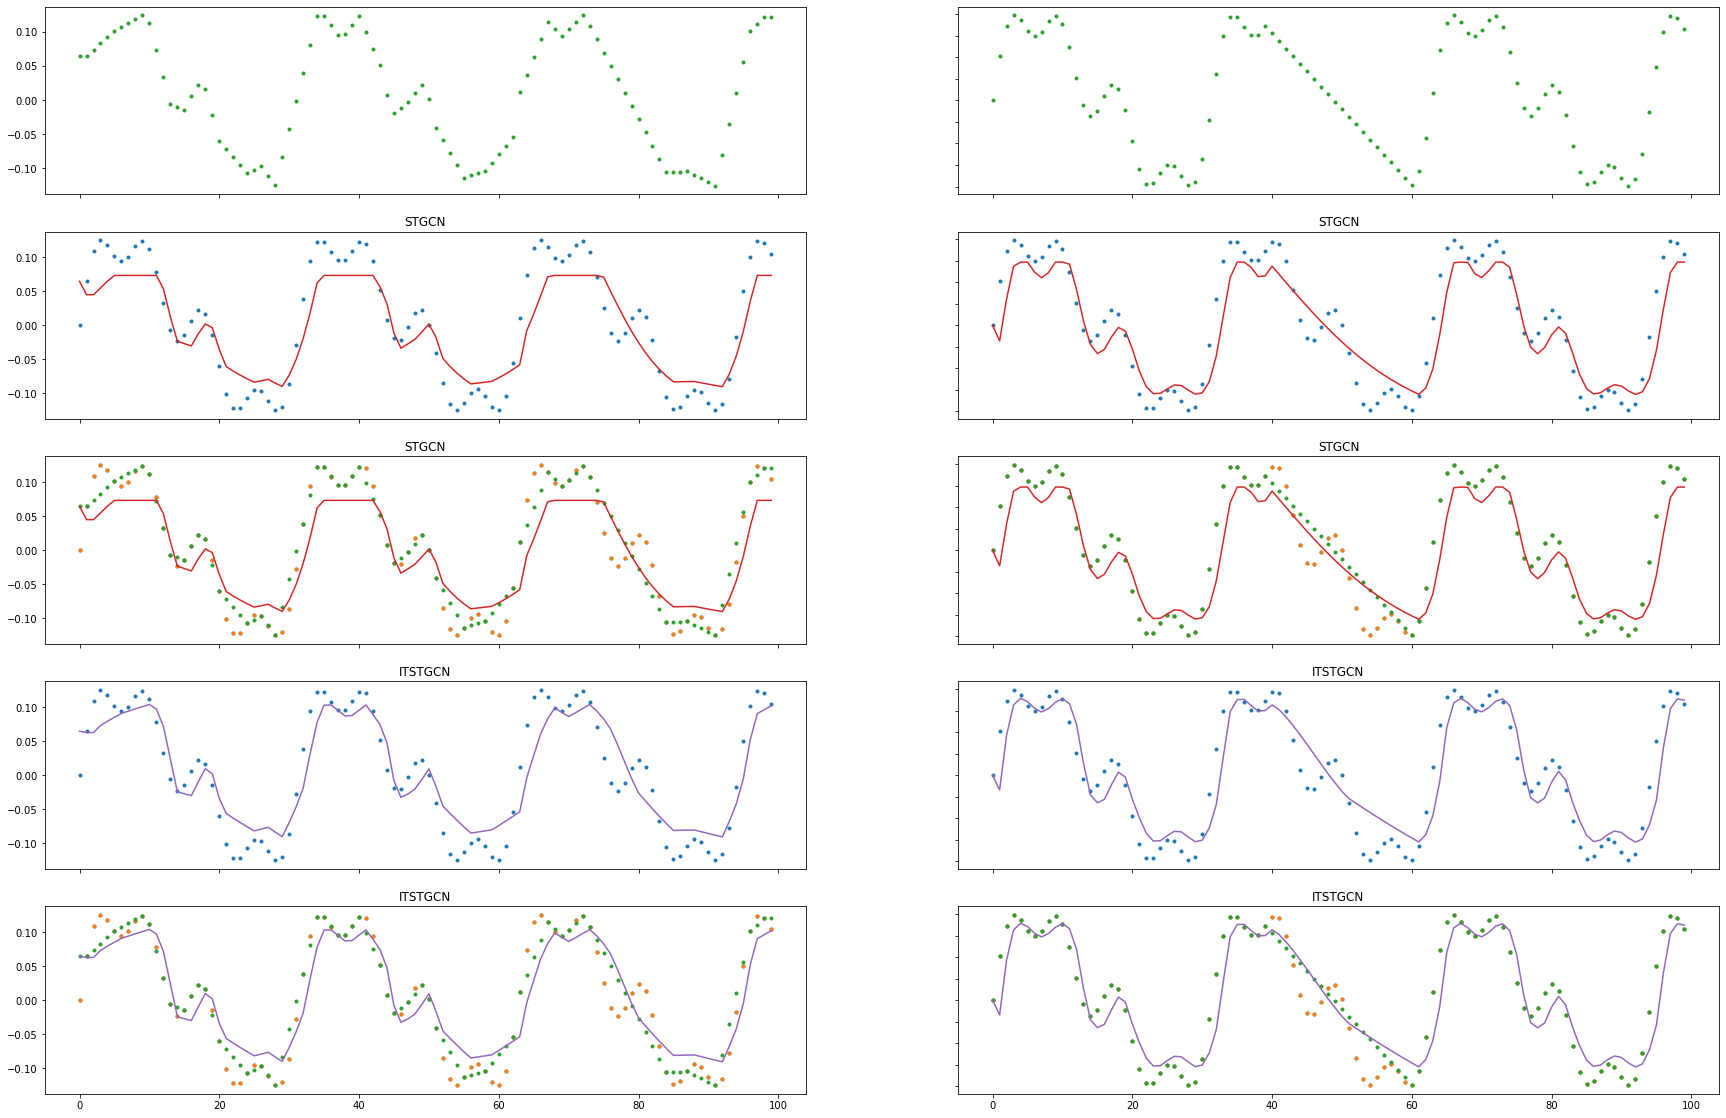

In [26]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2,figsize=(30,20))
# fig.suptitle('Figure 1')
ax1.plot(evtor05031.f_tr[:,0],'.',color='C2')
ax2.plot(evtor05031.f_tr[:,1],'.',color='C2')
ax3.plot(df1['x'][:],'.',color='C0')
ax3.plot(evtor05031.fhat_tr[:,0],color='C3')
ax3.set_title('STGCN')
ax4.plot(df1['y'][:],'.',color='C0')
ax4.plot(evtor05031.fhat_tr[:,1],color='C3')
ax4.set_title('STGCN')
ax5.plot(df1['x'][:],'.',color='C0')
ax5.plot(df1['xer'][:],'.',color='C1')
ax5.plot(evtor05031.f_tr[:,0],'.',color='C2')
ax5.plot(evtor05031.fhat_tr[:,0],color='C3')
ax5.set_title('STGCN')
ax6.plot(df1['y'][:],'.',color='C0')
ax6.plot(df1['yer'][:],'.',color='C1')
ax6.plot(evtor05031.f_tr[:,1],'.',color='C2')
ax6.plot(evtor05031.fhat_tr[:,1],color='C3')
ax6.set_title('STGCN')
ax7.plot(df1['x'][:],'.',color='C0')
ax7.plot(evtor05032.fhat_tr[:,0],color='C4')
ax7.set_title('ITSTGCN')
ax8.plot(df1['y'][:],'.',color='C0')
ax8.plot(evtor05032.fhat_tr[:,1],color='C4')
ax8.set_title('ITSTGCN')
ax9.plot(df1['x'][:],'.',color='C0')
ax9.plot(df1['xer'][:],'.',color='C1')
ax9.plot(evtor05032.f_tr[:,0],'.',color='C2')
ax9.plot(evtor05032.fhat_tr[:,0],color='C4')
ax9.set_title('ITSTGCN')
ax10.plot(df1['y'][:],'.',color='C0')
ax10.plot(df1['yer'][:],'.',color='C1')
ax10.plot(evtor05032.f_tr[:,1],'.',color='C2')
ax10.plot(evtor05032.fhat_tr[:,1],color='C4')
ax10.set_title('ITSTGCN')

for ax in fig.get_axes():
    ax.label_outer()

---

---

---

---

---

---

---

In [412]:
f = torch.tensor(np.stack([x+eps_x,y+eps_y],axis=1)).reshape(100,2,1).float()

In [317]:
(x+eps_x).shape,(y+eps_y).shape

((100,), (100,))

In [318]:
f.shape

torch.Size([100, 2, 1])

In [319]:
X = f[:99,:,:]
y = f[1:,:,:]

In [320]:
X.shape

torch.Size([99, 2, 1])

In [321]:
y.shape

torch.Size([99, 2, 1])

In [322]:
E = np.array([[0,1]]).T

In [323]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1]),dtype=torch.float32)

_ee = enumerate(zip(X,y))

In [324]:
edge_index

tensor([[0],
        [1]])

In [325]:
edge_attr

tensor([1.])

In [326]:
from tqdm import tqdm

model = RecurrentGCN(node_features=1, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(dataset_padded_cubic05031):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [01:21<00:00,  1.62s/it]


In [327]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

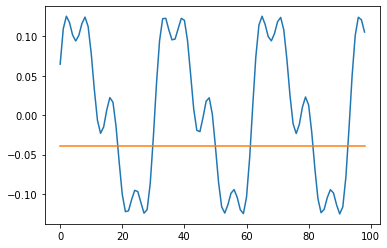

In [328]:
plt.plot(y[:,0,0],)
plt.plot(yhat[:,0,0])

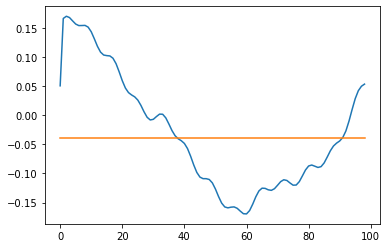

In [329]:
plt.plot(y[:,1,0],)
plt.plot(yhat[:,1,0])